In [3]:
import xarray as xr
import tqdm as tqdm
import numpy as np
import pandas as pd
import urllib.request

In [51]:
xr.open_dataset('/datadrive/tigge/16km/total_precipitation/2019-10.nc').tp.isel(init_time=0, lead_time=-1).max()

<xarray.DataArray 'tp' ()>
array(122.03633118)
Coordinates:
    init_time  datetime64[ns] 2019-10-01
    lead_time  timedelta64[ns] 2 days

## HRRR

In [5]:
start_date = '2019-10-01'
stop_date = '2019-11-01'
init_dates = pd.to_datetime(np.arange(start_date, stop_date, np.timedelta64(12, 'h'), dtype='datetime64[h]'))
# init_dates

In [6]:
lead_times = np.arange(0, 36+6, 6)
lead_times

array([ 0,  6, 12, 18, 24, 30, 36])

In [7]:
tmp_path = '/datadrive/tmp/'
save_path = '/datadrive/hrrr/raw/'

In [8]:
!ls $save_path/

20190901_00.nc	20190902_12.nc	20190904_00.nc	20190905_12.nc	20190907_12.nc
20190901_12.nc	20190903_00.nc	20190904_12.nc	20190906_00.nc	20190908_00.nc
20190902_00.nc	20190903_12.nc	20190905_00.nc	20190907_00.nc


In [9]:
ds_in = xr.open_dataset('/datadrive/hrrr/raw/20190901_00.nc')

In [11]:
km = 4
lats=[50,20]
lons=[235,290]

In [12]:
ddeg_out = km/100.

In [13]:
global_grid = xr.Dataset(
        {
            'lat': (['lat'], np.arange(90, -90, -ddeg_out)),
            'lon': (['lon'], np.arange(0, 360, ddeg_out)),
        }
    )

In [14]:
lats = lats or (np.round(ds_in.lat.max()).values, np.round(ds_in.lat.min()).values)
lons = lons or (np.round(ds_in.lon.min()).values, np.round(ds_in.lon.max()).values)
grid_out = global_grid.sel(lat=slice(*lats), lon=slice(*lons))

In [15]:
import xesmf as xe

In [16]:
regridder = xe.Regridder(
        ds_in, grid_out, 'bilinear', periodic=False
    )

In [17]:
ds_out = regridder(ds_in)

using dimensions ('y', 'x') from data variable tp as the horizontal dimensions for this dataset.


/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xesmf/frontend.py:515: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [22]:
import cartopy.crs as ccrs

In [28]:
rq = xr.open_dataset('/datadrive/mrms/raw/RadarQualityIndex/MRMS_RadarQualityIndex_00.00_20200516-000000.nc').tp

In [30]:
rq = rq.coarsen(lat=4, lon=4).mean()

In [31]:
rq = rq.sel(lat=slice(50, 20), lon=slice(235, 290)).isel(time=0)

In [34]:
rq1 = rq> 0

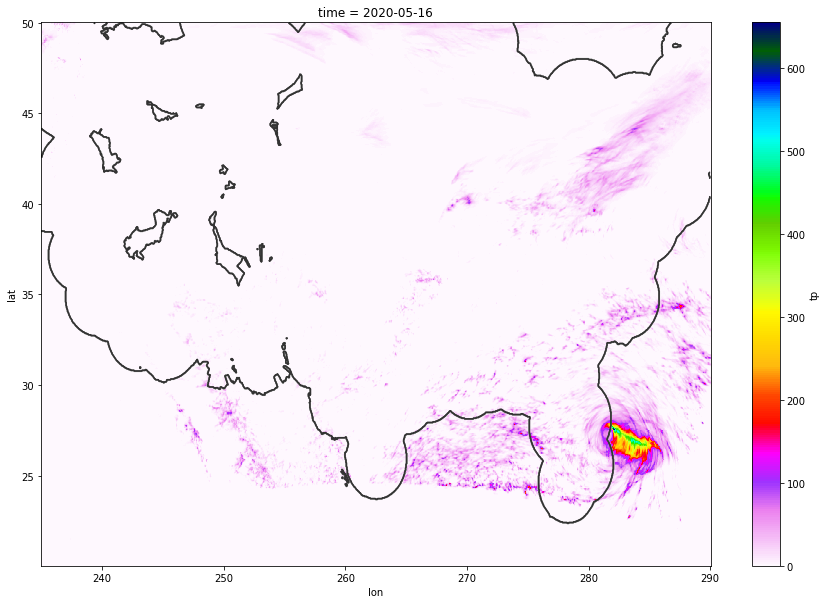

In [54]:
fig = plt.figure(figsize=(15, 10))
ds_out.tp.isel(init_time=0, lead_time=-1).plot(cmap='gist_ncar_r')
rq1.plot.contour(cmap='gray_r')

In [53]:
import matplotlib.pyplot as plt

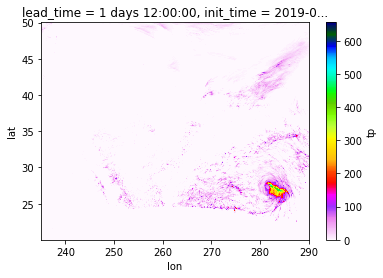

In [41]:
ds_out.tp.isel(init_time=0, lead_time=-1).plot(cmap='gist_ncar_r')

In [10]:
a = xr.open_mfdataset('/datadrive/hrrr/raw/*.nc')
a

<xarray.Dataset>
Dimensions:    (init_time: 2, lead_time: 7, x: 1799, y: 1059)
Coordinates:
    lat        (y, x) float32 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    lon        (y, x) float32 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
  * lead_time  (lead_time) timedelta64[ns] 00:00:00 06:00:00 ... 1 days 12:00:00
  * init_time  (init_time) datetime64[ns] 2019-09-01 2019-09-01T12:00:00
Dimensions without coordinates: x, y
Data variables:
    tp         (init_time, lead_time, y, x) float32 dask.array<chunksize=(1, 7, 1059, 1799), meta=np.ndarray>

In [39]:
a.expand_dims('d').assign_coords(d=[date])

<xarray.Dataset>
Dimensions:    (d: 1, lead_time: 7, x: 1799, y: 1059)
Coordinates:
    lat        (y, x) float32 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    lon        (y, x) float32 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
  * lead_time  (lead_time) timedelta64[ns] 00:00:00 06:00:00 ... 1 days 12:00:00
    init_time  datetime64[ns] ...
  * d          (d) datetime64[ns] 2019-10-01
Dimensions without coordinates: x, y
Data variables:
    tp         (d, lead_time, y, x) float32 dask.array<chunksize=(1, 7, 1059, 1799), meta=np.ndarray>

In [6]:
date = init_dates[0]
date

Timestamp('2019-10-01 00:00:00')

In [54]:
import os

In [70]:
delete_grib=True

In [73]:
for date in tqdm.tqdm(init_dates[:1]):
    nc_fn = f'{save_path}/{date_str}_{str(date.hour).zfill(2)}.nc'
    if not os.path.exists(nc_fn):
        das = []
        tmp_fns = []
        for l in lead_times:

            # Download
            date_str = f'{date.year}{str(date.month).zfill(2)}{str(date.day).zfill(2)}'
            aws_path = f'https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.{date_str}/conus/hrrr.t{str(date.hour).zfill(2)}z.wrfsfcf{str(l).zfill(2)}.grib2'
            print(aws_path)
            tmp_fn = f'{tmp_path}/{date_str}_{str(date.hour).zfill(2)}_{str(l).zfill(2)}.grib2'
            tmp_fns.append(tmp_fn)
            print(tmp_fn)
            urllib.request.urlretrieve(aws_path, tmp_fn)

            # Convert
            var_name = 'APCP_P8_L1_GLC0_acc' + (f'{l}h' if l > 0 else '')
            da = xr.open_dataset(tmp_fn, engine='pynio')[var_name].rename('tp').rename(
                {'gridlat_0': 'lat', 'gridlon_0': 'lon', 'ygrid_0': 'y', 'xgrid_0': 'x'})
            das.append(da)
        
        # Concat and save
        da = xr.concat(das, xr.DataArray(lead_times.astype('timedelta64[h]'), dims='lead_time', name='lead_time'))
        da.coords['init_time'] = date
        # Convert from kg/m^2 to mm
        da = da / 997 * 1000
        da.to_netcdf(nc_fn)
        
        if delete_grib:
            for tmp_fn in tmp_fns: 
                os.remove(tmp_fn)
        

  0%|          | 0/1 [00:00<?, ?it/s]

https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20191001/conus/hrrr.t00z.wrfsfcf00.grib2
/datadrive/tmp//20191001_00_00.grib2
https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20191001/conus/hrrr.t00z.wrfsfcf06.grib2
/datadrive/tmp//20191001_00_06.grib2
https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20191001/conus/hrrr.t00z.wrfsfcf12.grib2
/datadrive/tmp//20191001_00_12.grib2
https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20191001/conus/hrrr.t00z.wrfsfcf18.grib2
/datadrive/tmp//20191001_00_18.grib2
https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20191001/conus/hrrr.t00z.wrfsfcf24.grib2
/datadrive/tmp//20191001_00_24.grib2
https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20191001/conus/hrrr.t00z.wrfsfcf30.grib2
/datadrive/tmp//20191001_00_30.grib2
https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20191001/conus/hrrr.t00z.wrfsfcf36.grib2
/datadrive/tmp//20191001_00_36.grib2


100%|██████████| 1/1 [00:35<00:00, 35.62s/it]


In [74]:
!ls /datadrive/hrrr/raw

20191001_00.nc


In [77]:
ds= xr.open_dataset('/datadrive/hrrr/raw/20191001_00.nc')

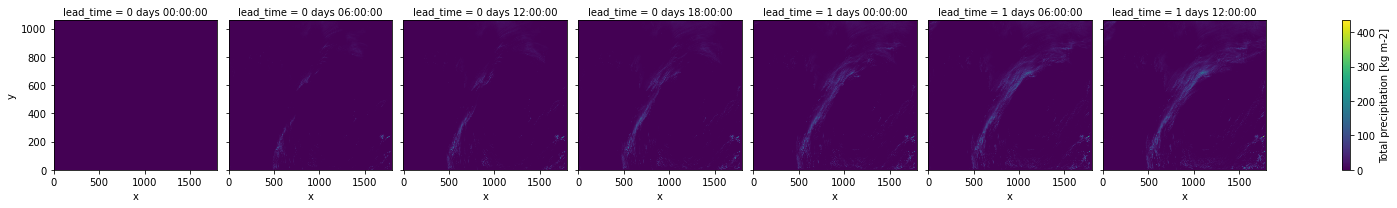

In [80]:
ds.tp.plot(col='lead_time')

In [ ]:
ds.isel(lead_time=)

In [68]:
lead_times.astype('timedelta64[h]')

array([ 0,  6, 12, 18, 24, 30, 36], dtype='timedelta64[h]')

In [64]:
date

Timestamp('2019-10-01 00:00:00')

In [84]:
xr.DataArray(date)

<xarray.DataArray ()>
array('2019-10-01T00:00:00.000000000', dtype='datetime64[ns]')

In [91]:
da = das[0]
da

<xarray.DataArray 'tp' (y: 1059, x: 1799)>
[1905141 values with dtype=float32]
Coordinates:
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...
Dimensions without coordinates: y, x
Attributes:
    center:                                         US National Weather Servi...
    production_status:                              Operational products
    long_name:                                      Total precipitation
    units:                                          kg m-2
    grid_type:                                      Lambert Conformal can be ...
    parameter_discipline_and_category:              Meteorological products, ...
    parameter_template_discipline_category_number:  [8 0 1 8]
    level_type:                                     Ground or water surface
    level:                                          [0.]
    type_of_statistical_processing:                 Accumulation
    statistical_process_duration:                   initial time to forecast ...
    forecast_time:                                  [0]
    forecast_time_units:                            hours
    initial_time:                                   10/01/2019 (00:00)

In [1]:
da.expand_dims('init_time')

NameError: name 'da' is not defined

In [66]:
da.coords['init_time'] = date

In [67]:
da

<xarray.DataArray 'tp' (ygrid_0: 1059, xgrid_0: 1799)>
[1905141 values with dtype=float32]
Coordinates:
    gridlat_0  (ygrid_0, xgrid_0) float32 ...
    gridlon_0  (ygrid_0, xgrid_0) float32 ...
    init_time  datetime64[ns] 2019-10-01
Dimensions without coordinates: ygrid_0, xgrid_0
Attributes:
    center:                                         US National Weather Servi...
    production_status:                              Operational products
    long_name:                                      Total precipitation
    units:                                          kg m-2
    grid_type:                                      Lambert Conformal can be ...
    parameter_discipline_and_category:              Meteorological products, ...
    parameter_template_discipline_category_number:  [8 0 1 8]
    level_type:                                     Ground or water surface
    level:                                          [0.]
    type_of_statistical_processing:                 Accumulation
    statistical_process_duration:                   36 hours (ending at forec...
    forecast_time:                                  [36]
    forecast_time_units:                            hours
    initial_time:                                   10/01/2019 (00:00)

In [62]:
xr.concat(das, xr.DataArray(lead_times, dims='lead_time', name='lead_time'))

<xarray.DataArray 'tp' (lead_time: 7, ygrid_0: 1059, xgrid_0: 1799)>
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.02      , 0.02      , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.02      , 0.02      , ..., 0.        ,
         0.        , 0.        ],
...
        [0.        , 0.        , 0.        , ..., 3.3       ,
         1.25      , 0.        ],
        [0.        , 0.        , 0.        , ..., 2.3799999 ,
         0.83      , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.02      , 0.02      , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.02      , 0.02      , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 4.52      ,
         1.5899999 , 0.        ],
        [0.        , 0.        , 0.        , ..., 3.06      ,
         1.02      , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)
Coordinates:
    gridlat_0  (ygrid_0, xgrid_0) float32 21.14 21.15 21.15 ... 47.85 47.84
    gridlon_0  (ygrid_0, xgrid_0) float32 -122.7 -122.7 -122.7 ... -60.95 -60.92
  * lead_time  (lead_time) int64 0 6 12 18 24 30 36
Dimensions without coordinates: ygrid_0, xgrid_0
Attributes:
    center:                                         US National Weather Servi...
    production_status:                              Operational products
    long_name:                                      Total precipitation
    units:                                          kg m-2
    grid_type:                                      Lambert Conformal can be ...
    parameter_discipline_and_category:              Meteorological products, ...
    parameter_template_discipline_category_number:  [8 0 1 8]
    level_type:                                     Ground or water surface
    level:                                          [0.]
    type_of_statistical_processing:                 Accumulation
    statistical_process_duration:                   initial time to forecast ...
    forecast_time:                                  [0]
    forecast_time_units:                            hours
    initial_time:                                   10/01/2019 (00:00)

In [57]:
ds1 = xr.open_dataset('/datadrive/tmp/20191001_00_00.grib2', engine='pynio')

In [58]:
ds1.APCP_P8_L1_GLC0_acc
ds1.APCP_P8_L1_GLC0_acc

<xarray.DataArray 'APCP_P8_L1_GLC0_acc' (ygrid_0: 1059, xgrid_0: 1799)>
[1905141 values with dtype=float32]
Coordinates:
    gridlat_0  (ygrid_0, xgrid_0) float32 ...
    gridlon_0  (ygrid_0, xgrid_0) float32 ...
Dimensions without coordinates: ygrid_0, xgrid_0
Attributes:
    center:                                         US National Weather Servi...
    production_status:                              Operational products
    long_name:                                      Total precipitation
    units:                                          kg m-2
    grid_type:                                      Lambert Conformal can be ...
    parameter_discipline_and_category:              Meteorological products, ...
    parameter_template_discipline_category_number:  [8 0 1 8]
    level_type:                                     Ground or water surface
    level:                                          [0.]
    type_of_statistical_processing:                 Accumulation
    statistical_process_duration:                   initial time to forecast ...
    forecast_time:                                  [0]
    forecast_time_units:                            hours
    initial_time:                                   10/01/2019 (00:00)

In [42]:
ds2 = xr.open_dataset('/datadrive/tmp/20191001_00_06.grib2', engine='pynio')

In [ ]:
ds2.APCP_P8_L1_GLC0_acc6h

In [45]:
ds3 = xr.open_dataset('/datadrive/tmp/20191001_00_12.grib2', engine='pynio')

In [46]:
ds3.APCP_P8_L1_GLC0_acc12h

<xarray.DataArray 'APCP_P8_L1_GLC0_acc12h' (ygrid_0: 1059, xgrid_0: 1799)>
[1905141 values with dtype=float32]
Coordinates:
    gridlat_0  (ygrid_0, xgrid_0) float32 ...
    gridlon_0  (ygrid_0, xgrid_0) float32 ...
Dimensions without coordinates: ygrid_0, xgrid_0
Attributes:
    center:                                         US National Weather Servi...
    production_status:                              Operational products
    long_name:                                      Total precipitation
    units:                                          kg m-2
    grid_type:                                      Lambert Conformal can be ...
    parameter_discipline_and_category:              Meteorological products, ...
    parameter_template_discipline_category_number:  [8 0 1 8]
    level_type:                                     Ground or water surface
    level:                                          [0.]
    type_of_statistical_processing:                 Accumulation
    statistical_process_duration:                   12 hours (ending at forec...
    forecast_time:                                  [12]
    forecast_time_units:                            hours
    initial_time:                                   10/01/2019 (00:00)

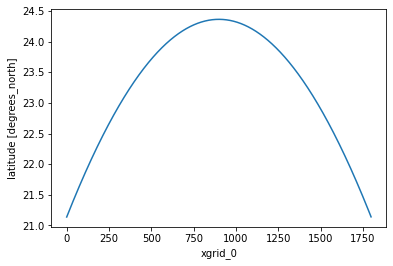

In [53]:
ds3.gridlat_0[0].plot()

In [52]:
ds3.xgrid_0

<xarray.DataArray 'xgrid_0' (xgrid_0: 1799)>
array([   0,    1,    2, ..., 1796, 1797, 1798])
Dimensions without coordinates: xgrid_0

In [1]:
!wget https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20200112/conus/hrrr.t00z.wrfsfcf18.grib2

--2021-01-19 14:40:22--  https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20200112/conus/hrrr.t00z.wrfsfcf18.grib2
Resolving noaa-hrrr-bdp-pds.s3.amazonaws.com (noaa-hrrr-bdp-pds.s3.amazonaws.com)... 52.216.204.75
Connecting to noaa-hrrr-bdp-pds.s3.amazonaws.com (noaa-hrrr-bdp-pds.s3.amazonaws.com)|52.216.204.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136316055 (130M) [binary/octet-stream]
Saving to: ‘hrrr.t00z.wrfsfcf18.grib2’

hrrr.t00z.wrfsfcf18 100%[===================>] 130.00M  35.4MB/s    in 4.3s    

2021-01-19 14:40:26 (30.4 MB/s) - ‘hrrr.t00z.wrfsfcf18.grib2’ saved [136316055/136316055]



In [2]:
import xarray as xr

In [21]:
ds = xr.open_dataset('hrrr.t00z.wrfsfcf18.grib2', engine='pynio')
ds

<xarray.Dataset>
Dimensions:                          (lv_HTGL10: 3, lv_HTGL2: 2, lv_HTGL3: 2, lv_HTGL7: 2, lv_HTGL8: 2, lv_HTGL9: 2, lv_ISBL0: 5, lv_ISBL1: 7, lv_ISBL5: 4, lv_SPDL6: 3, lv_TMPL4: 2, xgrid_0: 1799, ygrid_0: 1059)
Coordinates:
  * lv_HTGL8                         (lv_HTGL8) float32 1e+03 4e+03
  * lv_ISBL5                         (lv_ISBL5) float32 5e+04 7e+04 ... 1e+05
  * lv_TMPL4                         (lv_TMPL4) float32 253.0 263.0
  * lv_HTGL2                         (lv_HTGL2) float32 10.0 80.0
  * lv_ISBL1                         (lv_ISBL1) float32 2.5e+04 3e+04 ... 1e+05
  * lv_ISBL0                         (lv_ISBL0) float32 5e+04 7e+04 ... 1e+05
    gridlat_0                        (ygrid_0, xgrid_0) float32 ...
    gridlon_0                        (ygrid_0, xgrid_0) float32 ...
Dimensions without coordinates: lv_HTGL10, lv_HTGL3, lv_HTGL7, lv_HTGL9, lv_SPDL6, xgrid_0, ygrid_0
Data variables:
    TMP_P0_L1_GLC0                   (ygrid_0, xgrid_0) float32 ...
    TMP_P0_L100_GLC0                 (lv_ISBL0, ygrid_0, xgrid_0) float32 ...
    TMP_P0_L103_GLC0                 (ygrid_0, xgrid_0) float32 ...
    POT_P0_L103_GLC0                 (ygrid_0, xgrid_0) float32 ...
    DPT_P0_L100_GLC0                 (lv_ISBL0, ygrid_0, xgrid_0) float32 ...
    DPT_P0_L103_GLC0                 (ygrid_0, xgrid_0) float32 ...
    LHTFL_P0_L1_GLC0                 (ygrid_0, xgrid_0) float32 ...
    SHTFL_P0_L1_GLC0                 (ygrid_0, xgrid_0) float32 ...
    SPFH_P0_L103_GLC0                (ygrid_0, xgrid_0) float32 ...
    RH_P0_L4_GLC0                    (ygrid_0, xgrid_0) float32 ...
    RH_P0_L103_GLC0                  (ygrid_0, xgrid_0) float32 ...
    RH_P0_L204_GLC0                  (ygrid_0, xgrid_0) float32 ...
    PWAT_P0_L200_GLC0                (ygrid_0, xgrid_0) float32 ...
    PRATE_P0_L1_GLC0                 (ygrid_0, xgrid_0) float32 ...
    SNOD_P0_L1_GLC0                  (ygrid_0, xgrid_0) float32 ...
    WEASD_P0_L1_GLC0                 (ygrid_0, xgrid_0) float32 ...
    CRAIN_P0_L1_GLC0                 (ygrid_0, xgrid_0) float32 ...
    CFRZR_P0_L1_GLC0                 (ygrid_0, xgrid_0) float32 ...
    CICEP_P0_L1_GLC0                 (ygrid_0, xgrid_0) float32 ...
    CSNOW_P0_L1_GLC0                 (ygrid_0, xgrid_0) float32 ...
    CPOFP_P0_L1_GLC0                 (ygrid_0, xgrid_0) float32 ...
    SNOWC_P0_L1_GLC0                 (ygrid_0, xgrid_0) float32 ...
    RHPW_P0_L10_GLC0                 (ygrid_0, xgrid_0) float32 ...
    UGRD_P0_L100_GLC0                (lv_ISBL1, ygrid_0, xgrid_0) float32 ...
    UGRD_P0_L103_GLC0                (lv_HTGL2, ygrid_0, xgrid_0) float32 ...
    VGRD_P0_L100_GLC0                (lv_ISBL1, ygrid_0, xgrid_0) float32 ...
    VGRD_P0_L103_GLC0                (lv_HTGL2, ygrid_0, xgrid_0) float32 ...
    VUCSH_P0_2L103_GLC0              (lv_HTGL3, ygrid_0, xgrid_0) float32 ...
    VVCSH_P0_2L103_GLC0              (lv_HTGL3, ygrid_0, xgrid_0) float32 ...
    GUST_P0_L1_GLC0                  (ygrid_0, xgrid_0) float32 ...
    USTM_P0_2L103_GLC0               (ygrid_0, xgrid_0) float32 ...
    VSTM_P0_2L103_GLC0               (ygrid_0, xgrid_0) float32 ...
    FRICV_P0_L1_GLC0                 (ygrid_0, xgrid_0) float32 ...
    PRES_P0_L1_GLC0                  (ygrid_0, xgrid_0) float32 ...
    PRES_P0_L2_GLC0                  (ygrid_0, xgrid_0) float32 ...
    PRES_P0_L3_GLC0                  (ygrid_0, xgrid_0) float32 ...
    PRES_P0_L4_GLC0                  (ygrid_0, xgrid_0) float32 ...
    PRES_P0_L204_GLC0                (ygrid_0, xgrid_0) float32 ...
    HGT_P0_L1_GLC0                   (ygrid_0, xgrid_0) float32 ...
    HGT_P0_L2_GLC0                   (ygrid_0, xgrid_0) float32 ...
    HGT_P0_L3_GLC0                   (ygrid_0, xgrid_0) float32 ...
    HGT_P0_L4_GLC0                   (ygrid_0, xgrid_0) float32 ...
    HGT_P0_L5_GLC0                   (ygrid_0, xgrid_0) float32 ...
    HGT_P0_L20_GLC0                  (lv_TMPL4, ygrid_0, xgrid_0

In [7]:
ds.APCP_P8_L1_GLC0_acc1h

<xarray.DataArray 'APCP_P8_L1_GLC0_acc1h' (ygrid_0: 1059, xgrid_0: 1799)>
[1905141 values with dtype=float32]
Coordinates:
    gridlat_0  (ygrid_0, xgrid_0) float32 ...
    gridlon_0  (ygrid_0, xgrid_0) float32 ...
Dimensions without coordinates: ygrid_0, xgrid_0
Attributes:
    center:                                         US National Weather Servi...
    production_status:                              Operational products
    long_name:                                      Total precipitation
    units:                                          kg m-2
    grid_type:                                      Lambert Conformal can be ...
    parameter_discipline_and_category:              Meteorological products, ...
    parameter_template_discipline_category_number:  [8 0 1 8]
    level_type:                                     Ground or water surface
    level:                                          [0.]
    type_of_statistical_processing:                 Accumulation
    statistical_process_duration:                   1 hours (ending at foreca...
    forecast_time:                                  [18]
    forecast_time_units:                            hours
    initial_time:                                   01/12/2020 (00:00)

## HREF

In [21]:
!wget https://data.nssl.noaa.gov/thredds/fileServer/FRDD/HREFv2/2020/20200101/href01_2020010100f001

--2021-01-21 15:35:43--  https://data.nssl.noaa.gov/thredds/fileServer/FRDD/HREFv2/2020/20200101/href01_2020010100f001
Resolving data.nssl.noaa.gov (data.nssl.noaa.gov)... 140.172.25.117
Connecting to data.nssl.noaa.gov (data.nssl.noaa.gov)|140.172.25.117|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 80041472 (76M) [application/octet-stream]
Saving to: ‘href01_2020010100f001’

href01_2020010100f0 100%[===================>]  76.33M  19.6MB/s    in 5.1s    

2021-01-21 15:35:48 (15.0 MB/s) - ‘href01_2020010100f001’ saved [80041472/80041472]



In [28]:
!mv href01_2020010100f001.nc href01_2020010100f001.grib2

In [ ]:
!wget https://data.nssl.noaa.gov/thredds/notebook/FRDD/HREFv2/2020/20200321/href01_2020032100f015?catalog=FRDD/HREFv2/2020/20200321/catalog.xml

In [30]:
!head href01_2020010100f001.grib2

GEMPAK DATA MANAGEMENT FILE                   �   
            �   �   �           ����             <�                                                                                                                                                                                                                                                                                                                                                                                                    +U1>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [29]:
xr.open_dataset('href01_2020010100f001.grib2', engine='pynio')

NIOError: Unable to open file